# CIFAR10 Classifier

In [115]:
import torch
import torchvision
import torchvision.transforms as transforms

## Prepare Data

In [116]:
valid_ratio = 0.3
transform = transforms.Compose([transforms.ToTensor()])

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

num_train = int((1.0 - valid_ratio) * len(cifar_train))
num_valid = int(valid_ratio * len(cifar_train))

train_set, valid_set = torch.utils.data.dataset.random_split(cifar_train, [num_train, num_valid])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=500, shuffle=True)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Boat', 'Truck')



Files already downloaded and verified


# Visualize Dataset


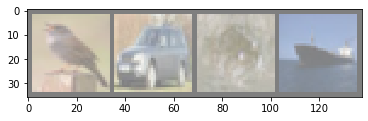

Bird   Car  Frog  Boat


In [117]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get iterater for loaded training images
dataiter = iter(train_loader)

# get the next batch of images and labels
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define CNN

In [118]:
import torch.nn as nn 
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0)

        self.fc1 = nn.Linear(16 * 6 * 6, 512) # Flatten output of previous layer
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        #input layer
        x = x
        
        # layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # layer 3
        x = self.conv3(x)
        x = F.relu(x)
  
        # layer 4
        # reshape by multiplying dimensions of x after previous layer
        x = x.view(-1, 16 * 6 * 6) 
        x = self.fc1(x)
        x = F.relu(x)

        # layer 5
        x = self.fc2(x)
        x = F.relu(x)
        
        # Output layer
        x = self.fc3(x)

        return x


## Training Loop

In [119]:
def get_num_correct(predictions, labels):
  return predictions.argmax(dim=1).eq(labels).sum().item()

In [120]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01) # parameters are weights and baises

train_loss = []
valid_loss = []
for epoch in range(10):
    total_correct = 0
    batch_loss = []
    for batch in train_loader:
        images, labels = batch

        predictions = network(images)
        loss = F.cross_entropy(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    
    train_loss.append(sum(batch_loss)/len(batch_loss))
    
    with torch.no_grad():
        batch_loss = []
        for batch in valid_loader:
            images, labels = batch

            predictions = network(images)
            loss = F.cross_entropy(predictions, labels)
            batch_loss.append(loss.item())
        
        valid_loss.append(sum(batch_loss)/len(batch_loss))
    
    print(f"epoch: {epoch} \t train loss: {train_loss[-1]} \t valid loss: {valid_loss[-1]}")





epoch: 0 	 train loss: 2.302802406038557 	 valid loss: 2.2259023745854694
epoch: 1 	 train loss: 2.1011746117046903 	 valid loss: 1.9992616732915243
epoch: 2 	 train loss: 1.9193666066442217 	 valid loss: 1.8258910298347473
epoch: 3 	 train loss: 1.819626866068159 	 valid loss: 1.8033386627833048
epoch: 4 	 train loss: 1.7529808895928518 	 valid loss: 1.7387651681900025
epoch: 5 	 train loss: 1.7125882949147906 	 valid loss: 1.7211021184921265
epoch: 6 	 train loss: 1.684600968020303 	 valid loss: 1.6835070490837096
epoch: 7 	 train loss: 1.6732950483049664 	 valid loss: 1.6753984928131103
epoch: 8 	 train loss: 1.6652430602482386 	 valid loss: 1.672759219010671
epoch: 9 	 train loss: 1.6471998010362898 	 valid loss: 1.6792854070663452


## Training Visualization

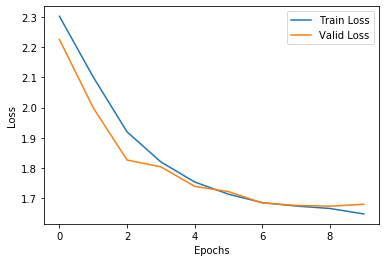

In [121]:
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Prepare Testing Data















In [122]:
# transform = transforms.Compose([transforms.ToTensor()])

cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=500, shuffle=True)

Files already downloaded and verified


## Calculate Testing Accuracy

In [0]:
total_correct = 0
for batch in test_loader:
    images, labels = next(batch_iter)
    predictions = network(images)
    total_correct += predictions.argmax(dim=1).eq(labels).sum().item()

print(f"Test accuracy: {total_correct/len(test_loader)}")

